In [1]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

In [2]:
api_token = {"username":"username","key":"key"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

In [3]:
!kaggle datasets download -d fernando2rad/brain-tumor-mri-images-44c

 98% 184M/188M [00:01<00:00, 135MB/s]
100% 188M/188M [00:01<00:00, 135MB/s]


In [4]:
!mkdir brain_dataset
%cd brain_dataset

/content/brain_dataset


In [5]:
!unzip -qq ../brain-tumor-mri-images-44c.zip

In [6]:
%cd ..

/content


In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image
import numpy as np
import os
import datetime
%matplotlib inline

In [8]:
tf.keras.utils.set_random_seed(1234)

In [9]:
imagePaths = "brain_dataset"

In [10]:
!ls -al brain_dataset

total 488
drwxr-xr-x 46 root root  4096 Mar 26 16:44  .
drwxr-xr-x  1 root root  4096 Mar 26 16:44  ..
drwxr-xr-x  2 root root 20480 Mar 26 16:44 'Astrocitoma T1'
drwxr-xr-x  2 root root 20480 Mar 26 16:44 'Astrocitoma T1C+'
drwxr-xr-x  2 root root 20480 Mar 26 16:44 'Astrocitoma T2'
drwxr-xr-x  2 root root  4096 Mar 26 16:44 'Carcinoma T1'
drwxr-xr-x  2 root root  4096 Mar 26 16:44 'Carcinoma T1C+'
drwxr-xr-x  2 root root  4096 Mar 26 16:44 'Carcinoma T2'
drwxr-xr-x  2 root root  4096 Mar 26 16:44 'Ependimoma T1'
drwxr-xr-x  2 root root  4096 Mar 26 16:44 'Ependimoma T1C+'
drwxr-xr-x  2 root root  4096 Mar 26 16:44 'Ependimoma T2'
drwxr-xr-x  2 root root  4096 Mar 26 16:44 'Ganglioglioma T1'
drwxr-xr-x  2 root root  4096 Mar 26 16:44 'Ganglioglioma T1C+'
drwxr-xr-x  2 root root  4096 Mar 26 16:44 'Ganglioglioma T2'
drwxr-xr-x  2 root root  4096 Mar 26 16:44 'Germinoma T1'
drwxr-xr-x  2 root root  4096 Mar 26 16:44 'Germinoma T1C+'
drwxr-xr-x  2 root root  4096 Mar 26 16:44 'Germinoma 

In [11]:
batch_size=16
img_height = 224
img_width = 224

In [12]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  imagePaths,
  #color_mode='grayscale',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4478 files belonging to 44 classes.
Using 3583 files for training.


In [13]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  imagePaths, 
  #color_mode='grayscale',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4478 files belonging to 44 classes.
Using 895 files for validation.


In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 224, 224, 3)
(16,)


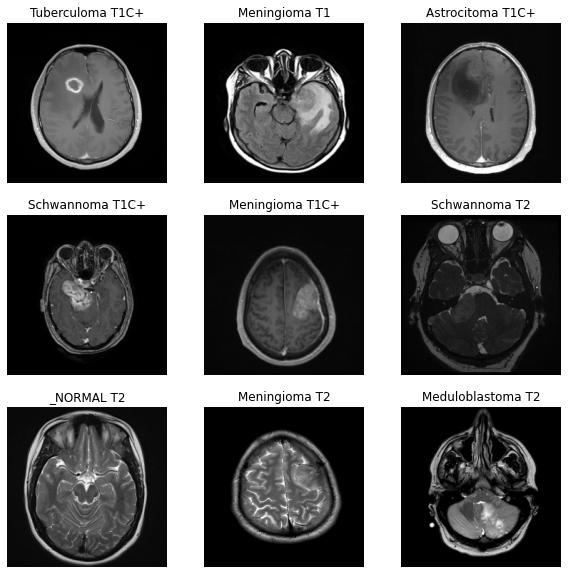

In [15]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap=plt.cm.bone)
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [16]:
data_augmentation= Sequential([
                               layers.RandomFlip("horizontal"),
                               layers.RandomBrightness(factor=0.1, value_range=(0, 255), seed=123)
])

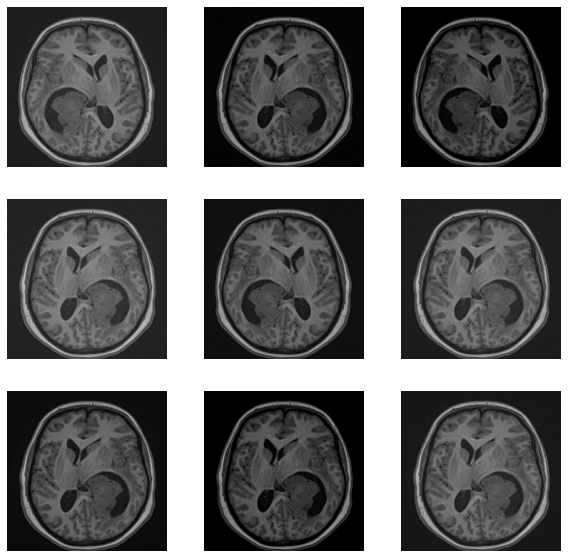

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"), cmap=plt.cm.bone)
        plt.axis("off")

In [18]:
resnet_base= tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
)

94765736/94765736 [==============================] - 0s 0us/step


In [19]:
x = resnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(44, activation='softmax')(x)
model = Model(inputs=resnet_base.input, 
              outputs=x)

In [21]:
def get_early_stopping():
    
    return tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [22]:
def get_checkpoint_best_only():
    
    checkpoint_best_path= 'checkpoints_best_only'
    checkpoint_best= ModelCheckpoint(filepath=checkpoint_best_path,
                           frequency='epoch',
                           save_weights_only=False,
                           monitor='val_accuracy',
                           save_best_only=True,
                           verbose=1)
    return checkpoint_best

In [23]:
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#callbacks = [checkpoint_best_only, early_stopping, tensorboard_callback]
callbacks = [checkpoint_best_only, tensorboard_callback, early_stopping]

In [24]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer


def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed. 
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))

In [25]:
y_train= tf.concat([y for x, y in train_ds], axis=0)

In [26]:
class_weights = generate_class_weights(y_train.numpy())

In [27]:
class_weights

{0: 0.5502149877149877,
 1: 0.4378054740957967,
 2: 0.5987633689839572,
 3: 1.4541396103896105,
 4: 0.8309369202226345,
 5: 1.507996632996633,
 6: 2.62683284457478,
 7: 2.1429425837320575,
 8: 1.6964962121212122,
 9: 4.285885167464115,
 10: 5.089488636363637,
 11: 4.523989898989899,
 12: 3.3929924242424243,
 13: 2.395053475935829,
 14: 3.3929924242424243,
 15: 1.8507231404958677,
 16: 1.057556080283353,
 17: 1.8507231404958677,
 18: 3.3929924242424243,
 19: 3.5405138339920947,
 20: 6.263986013986014,
 21: 5.089488636363637,
 22: 1.507996632996633,
 23: 2.5447443181818183,
 24: 0.37014462809917353,
 25: 0.27326113483831604,
 26: 0.43314796905222436,
 27: 0.7755411255411255,
 28: 0.4762094630515683,
 29: 1.0178977272727272,
 30: 1.1155043586550435,
 31: 1.3571969696969697,
 32: 1.507996632996633,
 33: 1.5364493996569468,
 34: 0.9253615702479339,
 35: 1.6286363636363637,
 36: 0.7019984326018809,
 37: 0.5089488636363636,
 38: 0.8395032802249297,
 39: 4.071590909090909,
 40: 1.2527972027972

In [28]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [29]:
history = model.fit(train_ds, validation_data=val_ds, batch_size=batch_size, epochs=50, 
                    class_weight=class_weights, callbacks=callbacks)

Epoch 1/50
224/224 [==============================] - ETA: 0s - loss: 3.4789 - accuracy: 0.1440
Epoch 1: val_accuracy improved from -inf to 0.06145, saving model to checkpoints_best_only


224/224 [==============================] - 122s 340ms/step - loss: 3.4789 - accuracy: 0.1440 - val_loss: 5.5100 - val_accuracy: 0.0615
Epoch 2/50
224/224 [==============================] - ETA: 0s - loss: 2.1513 - accuracy: 0.3455
Epoch 2: val_accuracy improved from 0.06145 to 0.17207, saving model to checkpoints_best_only


224/224 [==============================] - 74s 330ms/step - loss: 2.1513 - accuracy: 0.3455 - val_loss: 5.5913 - val_accuracy: 0.1721
Epoch 3/50
224/224 [==============================] - ETA: 0s - loss: 1.5605 - accuracy: 0.4773
Epoch 3: val_accuracy did not improve from 0.17207
224/224 [==============================] - 49s 218ms/step - loss: 1.5605 - accuracy: 0.4773 - val_loss: 15.1994 - val_accuracy: 0.0849
Epoch 4/50
224/224 [==============================] - ETA: 0s - loss: 1.1061 - accuracy: 0.5956
Epoch 4: val_accuracy improved from 0.17207 to 0.32849, saving model to checkpoints_best_only


224/224 [==============================] - 72s 321ms/step - loss: 1.1061 - accuracy: 0.5956 - val_loss: 2.8980 - val_accuracy: 0.3285
Epoch 5/50
224/224 [==============================] - ETA: 0s - loss: 0.6570 - accuracy: 0.7237
Epoch 5: val_accuracy improved from 0.32849 to 0.68380, saving model to checkpoints_best_only


224/224 [==============================] - 72s 322ms/step - loss: 0.6570 - accuracy: 0.7237 - val_loss: 1.1410 - val_accuracy: 0.6838
Epoch 6/50
224/224 [==============================] - ETA: 0s - loss: 0.4811 - accuracy: 0.7954
Epoch 6: val_accuracy did not improve from 0.68380
224/224 [==============================] - 49s 218ms/step - loss: 0.4811 - accuracy: 0.7954 - val_loss: 1.6836 - val_accuracy: 0.5654
Epoch 7/50
224/224 [==============================] - ETA: 0s - loss: 0.4151 - accuracy: 0.8183
Epoch 7: val_accuracy did not improve from 0.68380
224/224 [==============================] - 49s 218ms/step - loss: 0.4151 - accuracy: 0.8183 - val_loss: 1.5771 - val_accuracy: 0.5520
Epoch 8/50
224/224 [==============================] - ETA: 0s - loss: 0.3995 - accuracy: 0.8247
Epoch 8: val_accuracy improved from 0.68380 to 0.71285, saving model to checkpoints_best_only


224/224 [==============================] - 73s 324ms/step - loss: 0.3995 - accuracy: 0.8247 - val_loss: 1.0008 - val_accuracy: 0.7128
Epoch 9/50
224/224 [==============================] - ETA: 0s - loss: 0.2181 - accuracy: 0.9073
Epoch 9: val_accuracy improved from 0.71285 to 0.74302, saving model to checkpoints_best_only


224/224 [==============================] - 75s 333ms/step - loss: 0.2181 - accuracy: 0.9073 - val_loss: 0.8700 - val_accuracy: 0.7430
Epoch 10/50
224/224 [==============================] - ETA: 0s - loss: 0.0815 - accuracy: 0.9565
Epoch 10: val_accuracy improved from 0.74302 to 0.83240, saving model to checkpoints_best_only


224/224 [==============================] - 73s 325ms/step - loss: 0.0815 - accuracy: 0.9565 - val_loss: 0.6326 - val_accuracy: 0.8324
Epoch 11/50
224/224 [==============================] - ETA: 0s - loss: 0.0879 - accuracy: 0.9595
Epoch 11: val_accuracy did not improve from 0.83240
224/224 [==============================] - 49s 216ms/step - loss: 0.0879 - accuracy: 0.9595 - val_loss: 0.8270 - val_accuracy: 0.7665
Epoch 12/50
224/224 [==============================] - ETA: 0s - loss: 0.4097 - accuracy: 0.8339
Epoch 12: val_accuracy did not improve from 0.83240
224/224 [==============================] - 51s 227ms/step - loss: 0.4097 - accuracy: 0.8339 - val_loss: 1.6695 - val_accuracy: 0.5955
Epoch 13/50
224/224 [==============================] - ETA: 0s - loss: 0.3008 - accuracy: 0.8833
Epoch 13: val_accuracy did not improve from 0.83240
224/224 [==============================] - 49s 218ms/step - loss: 0.3008 - accuracy: 0.8833 - val_loss: 0.5993 - val_accuracy: 0.8313
Epoch 14/50
224/2

In [30]:
model.load_weights("checkpoints_best_only")

In [31]:
model.evaluate(val_ds)

56/56 [==============================] - 3s 54ms/step - loss: 0.6326 - accuracy: 0.8324


[0.6325991749763489, 0.832402229309082]

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [33]:
predictions = np.array([])
labels =  np.array([])
for x, y in val_ds:
  Y_pred=model.predict(x)
  y_prediction = np.argmax(Y_pred, axis=1)
  predictions = np.concatenate([predictions, y_prediction])
  labels = np.concatenate([labels, y.numpy()])

1/1 [==============================] - 0s 31ms/step


In [34]:
print('Confusion Matrix')
print(confusion_matrix(y_true=labels, y_pred=predictions))

Confusion Matrix
[[25  0  0 ...  0  0  0]
 [ 0 30  0 ...  0  0  0]
 [ 0  0 19 ...  0  0  5]
 ...
 [ 0  0  0 ...  2  0  0]
 [ 0  0  0 ...  0 49  0]
 [ 0  0  0 ...  0  0 56]]


In [35]:
classes= ["Astrocitoma T1", "Astrocitoma T1C+", "Astrocitoma T2", "Carcinoma T1", "Carcinoma T1C+", 
 "Carcinoma T2", "Ependimoma T1", "Ependimoma T1C+", "Ependimoma T2", "Ganglioglioma T1", "Ganglioglioma T1C+", 
 "Ganglioglioma T2", "Germinoma T1", "Germinoma T1C+", "Germinoma T2", "Glioblastoma T1", "Glioblastoma T1C+", 
 "Glioblastoma T2", "Granuloma T1", "Granuloma T1C+", "Granuloma T2", "Meduloblastoma T1", "Meduloblastoma T1C+", 
 "Meduloblastoma T2", "Meningioma T1"," Meningioma T1C+", "Meningioma T2", "Neurocitoma T1", "Neurocitoma T1C+", "Neurocitoma T2", 
 "Oligodendroglioma T1", "Oligodendroglioma T1C+", "Oligodendroglioma T2", "Papiloma T1", "Papiloma T1C+", "Papiloma T2", "Schwannoma T1", 
 "Schwannoma T1C+", "Schwannoma T2", "Tuberculoma T1", "Tuberculoma T1C+", "Tuberculoma T2", "_NORMAL T1", "_NORMAL T2"]

In [36]:
len(classes)

44

[[25  0  0 ...  0  0  0]
 [ 0 30  0 ...  0  0  0]
 [ 0  0 19 ...  0  0  5]
 ...
 [ 0  0  0 ...  2  0  0]
 [ 0  0  0 ...  0 49  0]
 [ 0  0  0 ...  0  0 56]]


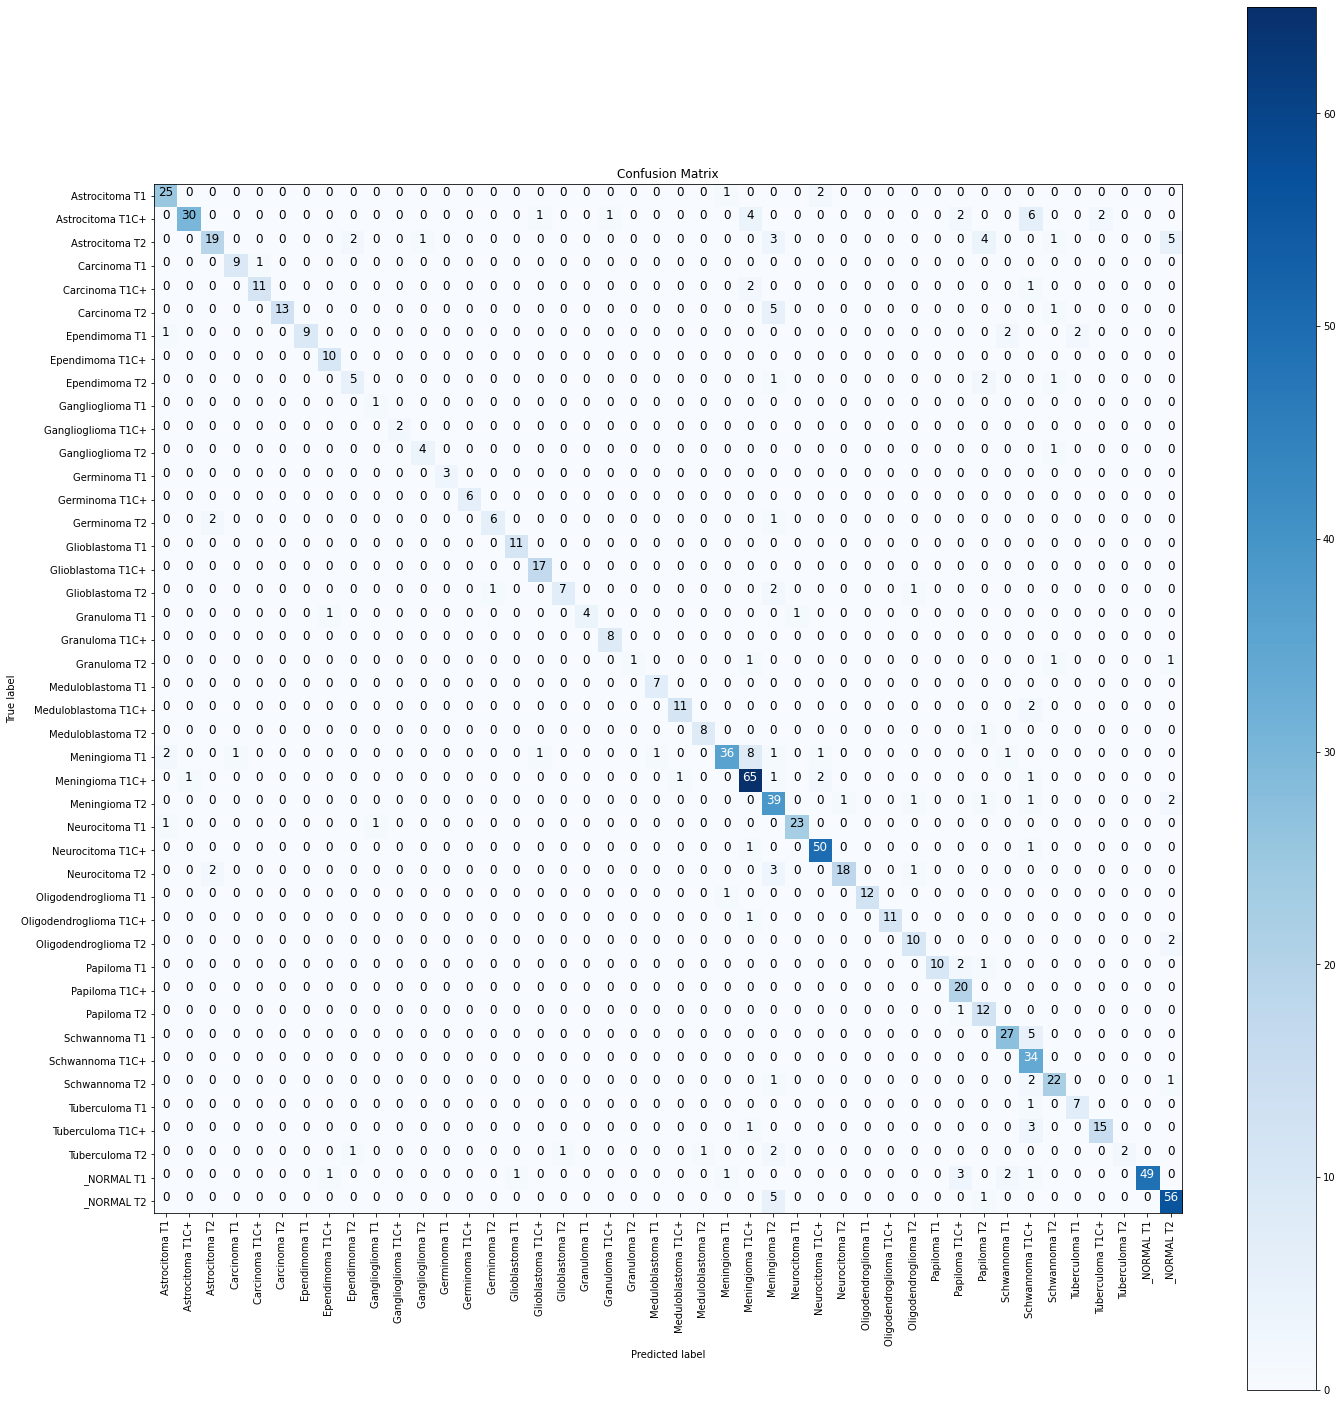

In [42]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):
    
    plt.figure(figsize = (20,20))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
#get confusion matrix
cm = confusion_matrix(labels, predictions)
print(cm)

#plot
plot_confusion_matrix(cm, classes, normalize=False)

In [39]:
print('Classification Report')
target_names = classes
print(classification_report(y_true=labels, y_pred=predictions, target_names=target_names))

Classification Report
                        precision    recall  f1-score   support

        Astrocitoma T1       0.86      0.89      0.88        28
      Astrocitoma T1C+       0.97      0.65      0.78        46
        Astrocitoma T2       0.83      0.54      0.66        35
          Carcinoma T1       0.90      0.90      0.90        10
        Carcinoma T1C+       0.92      0.79      0.85        14
          Carcinoma T2       1.00      0.68      0.81        19
         Ependimoma T1       1.00      0.64      0.78        14
       Ependimoma T1C+       0.83      1.00      0.91        10
         Ependimoma T2       0.62      0.56      0.59         9
      Ganglioglioma T1       0.50      1.00      0.67         1
    Ganglioglioma T1C+       1.00      1.00      1.00         2
      Ganglioglioma T2       0.80      0.80      0.80         5
          Germinoma T1       1.00      1.00      1.00         3
        Germinoma T1C+       1.00      1.00      1.00         6
          Germino